In [3]:
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [13]:
!curl "https://www.openml.org/data/get_csv/3624/dataset_191_wine.arff" > data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10988    0 10988    0     0  45032      0 --:--:-- --:--:-- --:--:-- 45032


In [14]:
dataset_df = pd.read_csv("data")
dataset_df.head()

,class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280%2FOD315_of_diluted_wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [23]:
dataset_df.shape

(178, 14)

In [16]:
np.unique(dataset_df['class'])

array([1, 2, 3])

In [22]:
X = dataset_df.drop(labels='class', axis=1).to_numpy()
y = dataset_df['class'].to_numpy()
X.shape, y.shape

((178, 13), (178,))

In [25]:
scaler = StandardScaler()
scaler.fit(X)
X_transformed = scaler.transform(X)
X_transformed.shape

(178, 13)

In [42]:
def principal_component_analysis(X: np.ndarray):
    covariance_matrix = np.cov(X.T)
    eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
    
    variance_explained = []
    for i in eigen_values:
         variance_explained.append((i/sum(eigen_values))*100)
            
    cumulative_variance_explained = np.cumsum(variance_explained)
    
    print(cumulative_variance_explained)
    
    projection_matrix = (eigen_vectors.T[:][:2]).T
    X_pca = X @ projection_matrix
    
    return X_pca

In [61]:
def plot_clusters(X_pca, y, title):
    plt.figure(figsize=(12, 12))
    colors = ["b", "g", "r"]
    
    unique_labels = np.unique(y)
    
    for idx, label in enumerate(unique_labels):
        
        cur_xs = X_pca[y == label, 0]
        cur_ys = X_pca[y == label, 1]
        
        plt.scatter(cur_xs, cur_ys, color=colors[idx], alpha=0.5, label=label)
        
    plt.title(title)
    plt.legend()
    plt.xlabel("X координата")
    plt.ylabel("Y координата")
    plt.show()

In [62]:
X_pca = principal_component_analysis(X_transformed)

[ 36.1988481   55.40633836  66.52996889  73.59899908  80.16229276
  85.09811607  89.3367954   90.13201029  92.81275924  94.11099181
  96.33314522  98.06998091 100.        ]


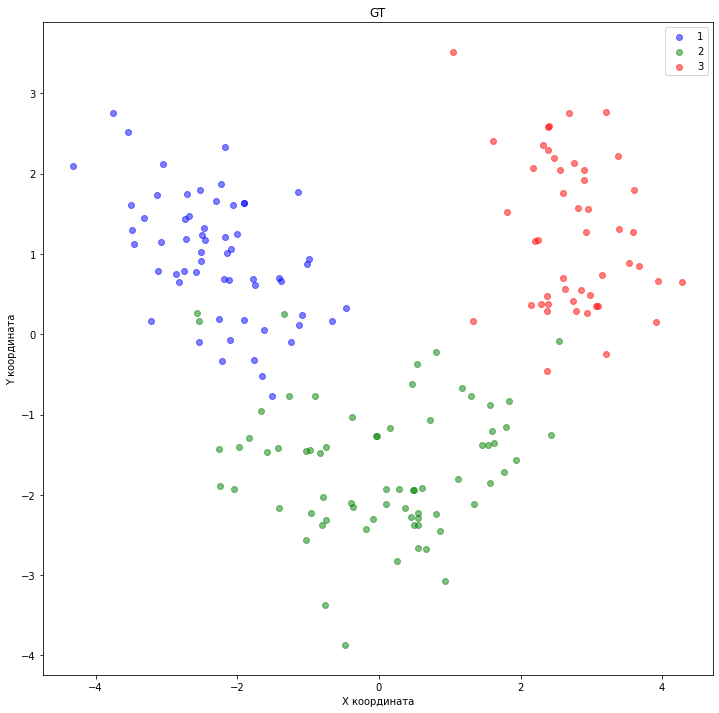

In [63]:
plot_clusters(X_pca, y, "GT")

In [122]:
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)


class KMeans:

    def __init__(
        self, 
        num_clusters, 
        distance_fn=euclidean_distance, 
        max_iters=10000, 
        eps=1e-7
    ):
        self.num_clusters = num_clusters
        self.eps = eps
        self.max_iters = max_iters
        self.distance_fn = distance_fn

        self.dim_ = None
        self.num_points_ = None
        self.centroids_ = None
        
        
    def find_closest_point(self, points, x):
        distances = np.array([self.distance_fn(p, x) for p in points])
        idx = np.argmin(distances)
        return idx, distances[idx]
    
    def find_closest_centroid(self, x):
        idx, fist = self.find_closest_point(self.centroids_, x)
        return idx

    def _init_centroids(self, X):
        num_points, dim = X.shape
        point_indices = np.arange(num_points)
        centroids = list()
        
        first_point = np.random.choice(point_indices)        
        centroids.append(X[first_point])
        
        for _ in range(self.num_clusters - 1):
            distances_to_centroids = \
                np.array([self.find_closest_point(centroids, x)[1] for x in X])
            sorted_indices = np.argsort(distances_to_centroids)
            sum_dists = np.sum(distances_to_centroids)
            
            chosen_dist = np.random.rand(1)[0] * sum_dists
            
            chosen_idx = 0
            cur_sum = distances_to_centroids[sorted_indices[0]]
            
            while cur_sum < chosen_dist:
                cur_sum += distances_to_centroids[sorted_indices[chosen_idx]]
                chosen_idx += 1

            centroids.append(X[sorted_indices[chosen_idx]])
            
        self.centroids_ = np.array(centroids)       
        self.num_points_ = num_points
        self.dim_ = dim
        
    def fit(self, X):
        self._init_centroids(X)
        
        for _ in range(self.max_iters):
            cluster_avg_vec = np.zeros((self.num_clusters, self.dim_), dtype=float)
            cluster_size = np.zeros(self.num_clusters, dtype=int)
            
            for point in X:
                cluster_size[self.find_closest_centroid(point)] += 1
                cluster_avg_vec[self.find_closest_centroid(point)] += point
                
            updated_centroids = np.copy(self.centroids_)
            cluster_avg_vec = cluster_avg_vec / cluster_size[:, None]
            
            updated_centroids[cluster_size != 0] = cluster_avg_vec[cluster_size != 0]
            
            diffs = [np.linalg.norm(d) for d in self.centroids_ - updated_centroids]
            
            if np.max(diffs) <= self.eps:
                break
                
            self.centroids_ = updated_centroids
            
    def predict_one(self, x):
        return self.find_closest_centroid(x)
    
    
    def predict(self, X):
        return [self.predict_one(x) for x in X]

In [123]:
m = KMeans(3)
m.fit(X_transformed)
m.centroids_

array([[ 0.16490746,  0.87154706,  0.18689833,  0.52436746, -0.07547277,
        -0.97933029, -1.21524764,  0.72606354, -0.77970639,  0.94153874,
        -1.16478865, -1.29241163, -0.40708796],
       [-0.93900326, -0.39196582, -0.43920097,  0.20898793, -0.46377382,
        -0.05334831,  0.06690377, -0.01982215,  0.06479192, -0.88207529,
         0.45298189,  0.28973833, -0.75602559],
       [ 0.87809728, -0.30457633,  0.31894179, -0.66452366,  0.56488825,
         0.87650546,  0.94363903, -0.58558981,  0.58178294,  0.16718842,
         0.48372814,  0.76705349,  1.15834713]])

In [168]:
clusterization_labels = m.predict(X_transformed)

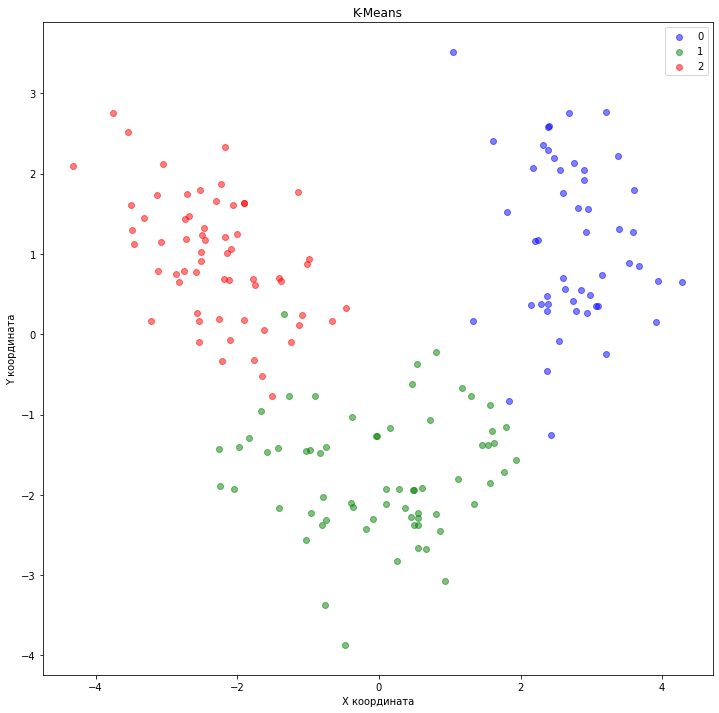

In [169]:
plot_clusters(X_pca, clusterization_labels, "K-Means")

In [213]:
def rand_index(X, labels, num_clusters):
    tp = tn = fp = fn = 0
    
    m = KMeans(num_clusters)
    m.fit(X)
    
    y_pred = m.predict(X)
    
    for i in range(len(labels)):
        for j in range(len(y_pred)):
            
            if labels[i] == labels[j] and y_pred[i] == y_pred[j]:
                tp += 1
            elif labels[i] == labels[j] and not y_pred[i] == y_pred[j]:
                fp += 1
            elif not labels[i] == labels[j] and y_pred[i] == y_pred[j]:
                tn += 1
            elif not labels[i] == labels[j] and not y_pred[i] == y_pred[j]:
                fn += 1
                
    return (tp + fn) / (tp + tn + fp + fn)

In [241]:
def cluster_diameter(X, model, num_clusters):
    y_hat = np.array(model.predict(X))
    max_distance = -1
    
    for cluster_idx in range(num_clusters):
        indices = (y_hat == cluster_idx)
        for point1 in X[indices]:
            for point2 in X[indices]:
                if not np.array_equal(point1, point2):
                    d = np.linalg.norm(point1 - point2)
                    if d > max_distance:
                        max_distance = d

    return max_distance


def between_cluster_distance(X, model, num_clusters):
    y_hat = np.array(model.predict(X))
    min_distance = 100000000
    
    for i in range(num_clusters):
        for j in range(num_clusters):
            if i != j:
                indices_i = (y_hat == i)
                indices_j = (y_hat == j)
                for point1 in X[indices_i]:
                    for point2 in X[indices_j]:
                        d = np.linalg.norm(point1 - point2)
                        if d < min_distance:
                            min_distance = d
    
    return min_distance


def dunn_metric(X, num_clusters):
    m = KMeans(num_clusters)
    m.fit(X)
    
    max_cluster_diameter = cluster_diameter(X, m, num_clusters)
    min_between_clust = between_cluster_distance(X, m, num_clusters)
    
    return min_between_clust / max_cluster_diameter

In [243]:
num_clusters = list(range(1, 10))
inner_metrics = list()
external_metrics = list()

for i in num_clusters:
    inner_metrics.append(dunn_metric(X_transformed, i))
    external_metrics.append(rand_index(X_transformed, y, i))

In [244]:
def plot_graph(num_clusters, metric_values, title):
    plt.figure(figsize=(12, 9))
    plt.grid(linestyle='--')
    plt.plot(num_clusters, metric_values, color='r')
    plt.title(title)
    plt.xlabel("Количество кластеров")
    plt.ylabel("Значение метрики")
    plt.show()

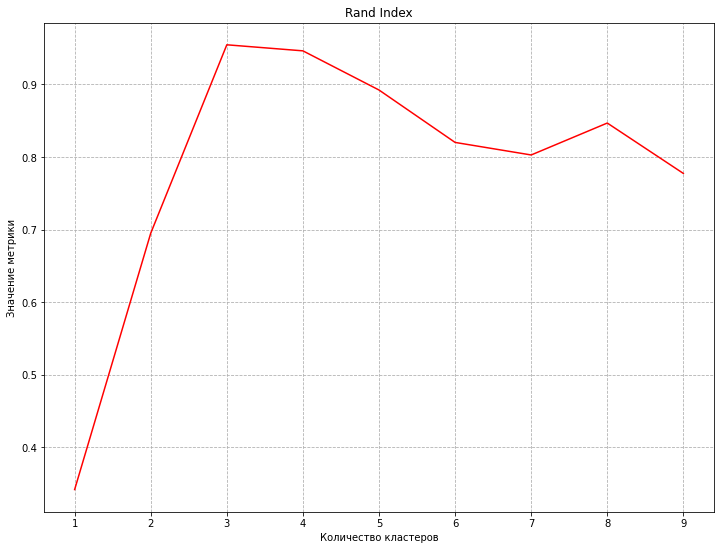

In [245]:
plot_graph(num_clusters, external_metrics, 'Rand Index')

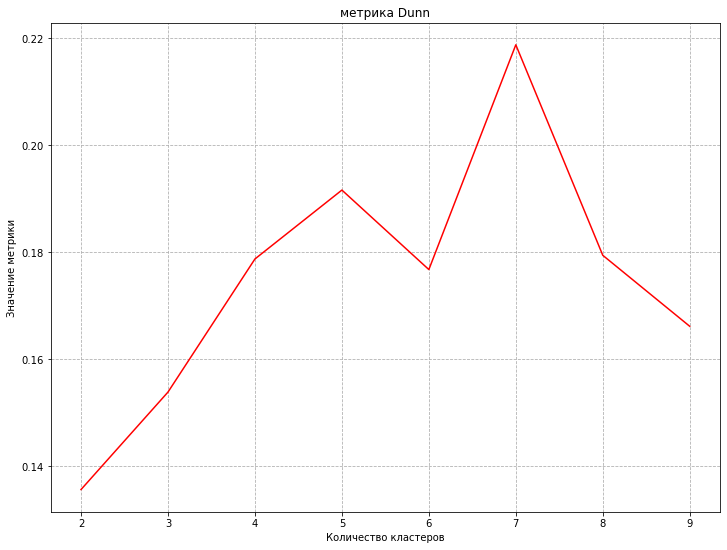

In [246]:
plot_graph(num_clusters[1:], inner_metrics[1:], 'метрика Dunn')